## Lab 1: Detecting Clickbait with Classical NLP

### Problem: Can We Automatically Identify Clickbait Headlines?

Clickbait headlines exploit curiosity gaps and emotional triggers to maximize engagement—"You won't BELIEVE what happened next!" or "This one weird trick doctors hate!" These sensationalized headlines undermine user trust and information quality. In this project, I'm exploring whether classical NLP methods from Lecture 2 can automatically detect these patterns.

### Approach: From Text to Vectors

To solve this with machine learning, we need to convert raw text into numerical features. This lab applies three foundational NLP techniques:

1. **Bag-of-Words (BoW)**: Count word frequencies—simple but ignores word order
2. **TF-IDF**: Weight words by their importance across the dataset—common words matter less
3. **N-grams**: Capture sequential patterns (e.g., bigrams like "shocking revelations" that unigrams miss)

We'll train a **Naive Bayes classifier** (the classical choice for text) and compare how different $n$-gram lengths and vocabulary sizes affect our ability to detect clickbait. This will demonstrate why these foundational methods motivate the evolution toward modern LLMs, which overcome the word-order limitation through attention mechanisms.

### Expected Outcome

By the end, we should see that bigrams outperform unigrams for clickbait detection, and TF-IDF may provide insights into which distinctive words or phrases signal clickbait. These simple methods form the building blocks for understanding how neural networks convert text into meaningful representations.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from collections import Counter
from typing import List, Dict
import re

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Libraries loaded')

Libraries loaded


## Step 1: Preprocessing Raw Text

Before we can count words, we need to clean and normalize raw text. This is the "hidden labor" of NLP: **what we do here directly impacts what features the classifier will see.**

**Each preprocessing step makes a tradeoff:**
- **Lowercasing**: Reduces feature dimensionality (treat "The" and "the" as the same word), but loses capitalization cues that might signal emphasis
- **Removing special characters**: Reduces noise and sparsity, but loses punctuation patterns (exclamation marks are common in clickbait!)
- **Tokenization**: Splits text into discrete words, which our vocabulary can index and count

The goal is to reduce noise while preserving the patterns that distinguish clickbait from legitimate news.

In [3]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the data
df = pd.read_csv('data/clickbait_data.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Clickbait distribution (before shuffle):\n{df['clickbait'].value_counts()}")

# SHUFFLE the dataset to avoid having all clickbait in first half and non-clickbait in second half
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nDataset shuffled and reset")

# Text preprocessing function - returns list of tokens
def preprocess_text(text: str) -> List[str]:
    """Clean and normalize text, return tokens"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove extra whitespace and split into tokens
    tokens = text.split()
    return tokens

# Apply preprocessing to create cleaned text
df['cleaned_text'] = df['headline'].apply(lambda x: ' '.join(preprocess_text(x)))

# Check preprocessing results
print("\nOriginal vs Cleaned:")
print(df[['headline', 'cleaned_text']].head(3))

# Split data BEFORE vectorization (prevents data leakage)
# Now take random samples from the shuffled dataset
max_train_samples = 1000
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'][:max_train_samples], 
    df['clickbait'][:max_train_samples],
    test_size=0.2,
    random_state=42,
    stratify=df['clickbait'][:max_train_samples]
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set class distribution:\n{y_train.value_counts()}")
print(f"\nTest set class distribution:\n{y_test.value_counts()}")

Dataset shape: (32000, 2)
Clickbait distribution (before shuffle):
clickbait
0    16001
1    15999
Name: count, dtype: int64

Dataset shuffled and reset

Original vs Cleaned:
                                            headline  \
0  Filipino activist arrested for disrupting Mani...   
1  International Board fixes soccer field size, h...   
2      24 Rules For Women On A First Date With A Man   

                                        cleaned_text  
0  filipino activist arrested for disrupting mani...  
1  international board fixes soccer field size ha...  
2      24 rules for women on a first date with a man  

Training set: 800 samples
Test set: 200 samples

Training set class distribution:
clickbait
1    411
0    389
Name: count, dtype: int64

Test set class distribution:
clickbait
1    103
0     97
Name: count, dtype: int64


## Step 2: Build Vocabulary

Next, we create a **vocabulary**: a mapping from words → vector indices. This is how we'll convert text into numerical vectors.

**The vocabulary size is a key hyperparameter:**
- **Larger vocabulary** (e.g., 2000 words): Captures more nuanced patterns and distinctive words
- **Smaller vocabulary** (e.g., 500 words): Faster computation, less sparsity, but might miss important signals

We keep only the most frequently occurring words in the training data. Words that appear only once are probably noise; rare words provide weak learning signals. By limiting vocabulary size, we focus on the patterns that appear consistently enough to matter.

This step is crucial: **a good vocabulary balances capturing meaningful language variation while reducing noise and computational cost.**

In [4]:
def build_vocabulary(documents: List[str], max_features: int = 2000) -> Dict[str, int]:
    """
    Build vocabulary from documents
    """
    # Collect all words
    all_words = []
    for doc in documents:
        tokens = preprocess_text(doc)
        all_words.extend(tokens)

    # Get most common words
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(max_features)
    # Create vocabulary dict
    vocabulary = {}  
    for word, count in most_common:
        vocabulary[word] = len(vocabulary)

    return vocabulary

# Test
print('Building vocabulary...')
vocab = build_vocabulary(X_train.tolist(), max_features=2000)
print(f'Vocabulary size: {len(vocab)}')

Building vocabulary...
Vocabulary size: 2000


In [5]:
def vectorize_document(document: str, vocabulary: Dict[str, int]) -> np.ndarray:
    """
    Convert document to vector
    """
    # Initialize vector
    vector = np.zeros(len(vocabulary), dtype=int)
    
    # Count words
    tokens = preprocess_text(document)
    word_counts = Counter(tokens)
    
    # Fill vector
    for word, count in word_counts.items():
        if word in vocabulary:
            vector[vocabulary[word]] = count
    
    return vector

# Vectorize all reviews
print('Vectorizing training data...')
X_bow_train = np.array([vectorize_document(r, vocab) for r in X_train])
X_bow_test = np.array([vectorize_document(r, vocab) for r in X_test])
print(f'✓ BoW matrix shape: {X_bow_train.shape}')

Vectorizing training data...
✓ BoW matrix shape: (800, 2000)


## Step 3: Calculate TF-IDF Vectors (Improving on Raw Counts)

**Raw word counts have a problem:** Common words like "the," "is," and "and" appear in almost every headline—both clickbait and legitimate. These frequent words don't help distinguish clickbait from non-clickbait.

**TF-IDF solves this by weighting words by their informativeness:**

- **TF (Term Frequency)**: How often does this word appear in *this* headline? 
- **IDF (Inverse Document Frequency)**: How rare is this word *across all headlines*? 
  - Common words get low IDF scores (they appear in many documents, so they're not distinctive)
  - Rare words get high IDF scores (they appear in few documents, making them more informative)
- **TF-IDF = TF × IDF**: The product balances word frequency with rarity

This is a refinement of Bag-of-Words: we're still treating text as unordered word counts, but now we've realized that **not all words are equally informative.** Words like "shocking," "exposed," and "you wont believe" might have high TF-IDF in clickbait but low in legitimate news.

We'll compare raw BoW vectors to TF-IDF vectors to see if downweighting common words improves clickbait detection.

In [6]:
def calculate_tf(document: str) -> Dict[str, float]:
    """
    Calculate term frequency
    """
    tokens = preprocess_text(document)
    total = len(tokens)
    if total == 0:
        return {}
    
    # Calculate TF for each word
    tf_scores = {}
    for word in set(tokens):
        tf_scores[word] = tokens.count(word) / total
    
    return tf_scores

def calculate_idf(documents: List[str], vocabulary: Dict[str, int]) -> Dict[str, float]:
    """
    Calculate inverse document frequency
    """
    total_docs = len(documents)
    doc_count = {word: 0 for word in vocabulary}
    
    # Count documents containing each word
    for doc in documents:
        unique_words = set(preprocess_text(doc))
        for word in unique_words:
            if word in doc_count:
                doc_count[word] += 1
    
    # Calculate IDF
    idf_scores = {}
    for word, count in doc_count.items():
        idf_scores[word] = np.log(total_docs / (count + 1))  # +1 to avoid division by zero
    
    return idf_scores

print('Calculating IDF...')
idf_scores = calculate_idf(X_train.tolist(), vocab)
print('✓ IDF calculated!')

Calculating IDF...
✓ IDF calculated!


In [7]:
def calculate_tfidf_vector(document: str, vocabulary: Dict[str, int], idf_scores: Dict[str, float]) -> np.ndarray:
    """
    Calculate TF-IDF vector
    """
    vector = np.zeros(len(vocabulary))
    tf_scores = calculate_tf(document)
    
    # Calculate TF-IDF = TF × IDF
    for word, tf in tf_scores.items():
        if word in vocabulary:
            idx = vocabulary[word]
            idf = idf_scores.get(word, 0)
            vector[idx] = tf * idf
    
    return vector

print('Creating TF-IDF vectors...')
X_tfidf_train = np.array([calculate_tfidf_vector(r, vocab, idf_scores) for r in X_train])
X_tfidf_test = np.array([calculate_tfidf_vector(r, vocab, idf_scores) for r in X_test])
print(f'✓ TF-IDF matrix shape: {X_tfidf_train.shape}')

Creating TF-IDF vectors...
✓ TF-IDF matrix shape: (800, 2000)


## Step 4: Extract N-grams (Recovering Word Order)

**A fundamental limitation of Bag-of-Words:** It ignores word order.

Both of these represent the same BoW vector: `{you: 1, won't: 1, believe: 1}`
- "You won't believe this"  
- "Believe this you won't"

For clickbait, order matters. The phrase "you won't believe" is a classic clickbait signal. Counting these words individually misses the pattern.

**N-grams recover some lost word order by capturing word sequences:**
- **Unigrams**: Individual words (BoW original)
- **Bigrams**: Two-word sequences ("you won't", "won't believe", "believe this")
- **Trigrams and beyond**: Three+ word sequences (more specific but exponentially sparser)

Bigrams let us capture distinctive clickbait phrases. The cost? **Feature explosion:** Each bigram is a new feature, so vocabulary size grows quickly. With 2000 unique words, we could have up to $2000^2$ possible bigrams (though in practice, most don't occur).

**Tradeoff:** Bigrams provide richer context but with computational and sparsity costs. For short texts like headlines, bigrams often help. For longer documents, the feature explosion becomes problematic—another motivation for modern LLMs to use learned attention patterns instead of explicit n-grams.

In [8]:
def extract_ngrams(text: str, n: int) -> List[str]:
    """
    Extract n-grams from text
    """
    tokens = preprocess_text(text)
    ngrams = []
    
    # Extract n-grams
    for i in range(len(tokens) - n + 1):
        ngram = ' '.join(tokens[i:i+n])
        ngrams.append(ngram)
    
    return ngrams

# Test with example
example = "these shocking headlines will make you click"
print(f"Unigrams: {extract_ngrams(example, 1)}")
print(f"Bigrams: {extract_ngrams(example, 2)}")

Unigrams: ['these', 'shocking', 'headlines', 'will', 'make', 'you', 'click']
Bigrams: ['these shocking', 'shocking headlines', 'headlines will', 'will make', 'make you', 'you click']


## Step 5: Train and Evaluate Classifiers

We'll use **Naive Bayes**, the classical algorithm for text classification. Here's why:

**Why Naive Bayes?**
- **Simple and efficient**: Trains and predicts quickly, even on high-dimensional text data
- **Surprisingly effective for text**: Despite its unrealistic assumptions, it works well in practice
- **The "naive" assumption**: Each word contributes independently to the prediction (e.g., presence of "shocking" is treated as independent from "revelations")

**The limitation:** Words in natural language are *not* independent. "Shocking revelations" has a different meaning than "shocking" and "revelations" separately. Naive Bayes ignores these dependencies—but empirically, this simplification often doesn't matter much for text classification.

**Interpreting the results:**
- Accuracy of ~78% on a balanced binary task beats random guessing (50%)
- Precision and recall per class tell us: Are we good at detecting clickbait? Are we falsely flagging legitimate news?

In [9]:
# Convert labels to numeric
y_train_numeric = y_train.values.astype(int)
y_test_numeric = y_test.values.astype(int)

# Train Naive Bayes with Bag of Words
print('Training Naive Bayes classifier with BoW...')
nb_bow = MultinomialNB()
nb_bow.fit(X_bow_train, y_train_numeric)

# Evaluate
y_pred_bow = nb_bow.predict(X_bow_test)
accuracy_bow = accuracy_score(y_test_numeric, y_pred_bow)

print(f'\n✓ BoW Accuracy: {accuracy_bow:.4f} ({accuracy_bow*100:.1f}%)')
print('\nClassification Report (BoW):')
print(classification_report(y_test_numeric, y_pred_bow, labels=[0, 1], target_names=['Not Clickbait', 'Clickbait']))

Training Naive Bayes classifier with BoW...

✓ BoW Accuracy: 0.9500 (95.0%)

Classification Report (BoW):
               precision    recall  f1-score   support

Not Clickbait       0.98      0.92      0.95        97
    Clickbait       0.93      0.98      0.95       103

     accuracy                           0.95       200
    macro avg       0.95      0.95      0.95       200
 weighted avg       0.95      0.95      0.95       200



In [10]:
# Train Naive Bayes with TF-IDF
print('\nTraining Naive Bayes classifier with TF-IDF...')
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_tfidf_train, y_train_numeric)

# Evaluate
y_pred_tfidf = nb_tfidf.predict(X_tfidf_test)
accuracy_tfidf = accuracy_score(y_test_numeric, y_pred_tfidf)

print(f'✓ TF-IDF Accuracy: {accuracy_tfidf:.4f} ({accuracy_tfidf*100:.1f}%)')
print('\nClassification Report (TF-IDF):')
print(classification_report(y_test_numeric, y_pred_tfidf, labels=[0, 1], target_names=['Not Clickbait', 'Clickbait']))


Training Naive Bayes classifier with TF-IDF...
✓ TF-IDF Accuracy: 0.9300 (93.0%)

Classification Report (TF-IDF):
               precision    recall  f1-score   support

Not Clickbait       0.97      0.89      0.92        97
    Clickbait       0.90      0.97      0.93       103

     accuracy                           0.93       200
    macro avg       0.93      0.93      0.93       200
 weighted avg       0.93      0.93      0.93       200



## Step 6: Compare Unigrams vs Bigrams with Different Vocabulary Sizes

**Hypothesis:** We expect bigrams to outperform unigrams for clickbait detection because:
1. Clickbait relies on distinctive *phrases* ("you won't believe," "shocking truth") not just isolated words
2. Bigrams should capture these phrase patterns while unigrams only count word frequency

We also expect TF-IDF to help by downweighting common words that appear equally in clickbait and legitimate headlines.

**Experiment:** We'll test four configurations across vocabulary sizes (500 → 2000 words):
- Unigrams + Bag-of-Words (baseline)
- Unigrams + TF-IDF 
- Bigrams + Bag-of-Words
- Bigrams + TF-IDF

**What to watch for:** Does performance plateau at larger vocabulary sizes? Does one configuration consistently outperform others? Are the accuracy improvements meaningful or marginal?

Data Distribution Analysis:
Training set class distribution:
clickbait
1    411
0    389
Name: count, dtype: int64

Test set class distribution:
clickbait
1    103
0     97
Name: count, dtype: int64

Test set ratio: 51.50% clickbait

Testing different n-gram configurations...

Vocabulary size: 500
  Unigrams (BoW): 0.9100 | Unigrams (TF-IDF): 0.9100
  Bigrams (BoW): 0.9100 | Bigrams (TF-IDF): 0.9000
  Unique predictions (Unigrams BoW): {np.int64(0), np.int64(1)}

Vocabulary size: 1000
  Unigrams (BoW): 0.9450 | Unigrams (TF-IDF): 0.9400
  Bigrams (BoW): 0.9250 | Bigrams (TF-IDF): 0.9200
  Unique predictions (Unigrams BoW): {np.int64(0), np.int64(1)}

Vocabulary size: 1500
  Unigrams (BoW): 0.9450 | Unigrams (TF-IDF): 0.9400
  Bigrams (BoW): 0.9400 | Bigrams (TF-IDF): 0.9400
  Unique predictions (Unigrams BoW): {np.int64(0), np.int64(1)}

Vocabulary size: 2000
  Unigrams (BoW): 0.9400 | Unigrams (TF-IDF): 0.9250
  Bigrams (BoW): 0.9450 | Bigrams (TF-IDF): 0.9500
  Unique predictions (Un

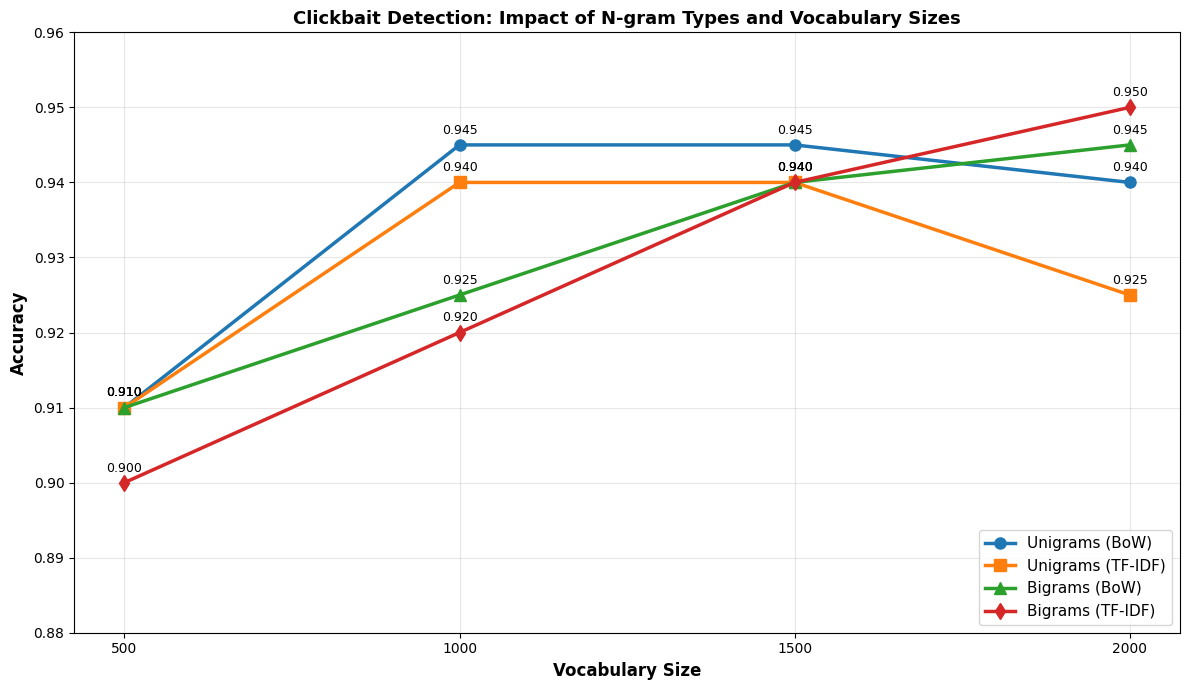

In [14]:
import matplotlib.pyplot as plt

# First, let's check the data distribution
print("Data Distribution Analysis:")
print(f"Training set class distribution:\n{y_train.value_counts()}\n")
print(f"Test set class distribution:\n{y_test.value_counts()}\n")
print(f"Test set ratio: {y_test.sum() / len(y_test):.2%} clickbait\n")

# Test different vocabulary sizes with unigrams and bigrams
vocab_sizes = [500, 1000, 1500, 2000]
results = {
    'unigrams_bow': [],
    'unigrams_tfidf': [],
    'bigrams_bow': [],
    'bigrams_tfidf': []
}

print("Testing different n-gram configurations...\n")

for vocab_size in vocab_sizes:
    print(f"Vocabulary size: {vocab_size}")
    
    # Unigrams with BoW
    vec_uni = CountVectorizer(max_features=vocab_size, ngram_range=(1, 1))
    X_uni_train = vec_uni.fit_transform(X_train)
    X_uni_test = vec_uni.transform(X_test)
    nb_uni = MultinomialNB()
    nb_uni.fit(X_uni_train, y_train_numeric)
    y_pred_uni_bow = nb_uni.predict(X_uni_test)
    acc_uni_bow = accuracy_score(y_test_numeric, y_pred_uni_bow)
    results['unigrams_bow'].append(acc_uni_bow)
    
    # Unigrams with TF-IDF
    vec_uni_tfidf = TfidfVectorizer(max_features=vocab_size, ngram_range=(1, 1))
    X_uni_tfidf_train = vec_uni_tfidf.fit_transform(X_train)
    X_uni_tfidf_test = vec_uni_tfidf.transform(X_test)
    nb_uni_tfidf = MultinomialNB()
    nb_uni_tfidf.fit(X_uni_tfidf_train, y_train_numeric)
    y_pred_uni_tfidf = nb_uni_tfidf.predict(X_uni_tfidf_test)
    acc_uni_tfidf = accuracy_score(y_test_numeric, y_pred_uni_tfidf)
    results['unigrams_tfidf'].append(acc_uni_tfidf)
    
    # Bigrams with BoW
    vec_bi = CountVectorizer(max_features=vocab_size, ngram_range=(1, 2))
    X_bi_train = vec_bi.fit_transform(X_train)
    X_bi_test = vec_bi.transform(X_test)
    nb_bi = MultinomialNB()
    nb_bi.fit(X_bi_train, y_train_numeric)
    y_pred_bi_bow = nb_bi.predict(X_bi_test)
    acc_bi_bow = accuracy_score(y_test_numeric, y_pred_bi_bow)
    results['bigrams_bow'].append(acc_bi_bow)
    
    # Bigrams with TF-IDF
    vec_bi_tfidf = TfidfVectorizer(max_features=vocab_size, ngram_range=(1, 2))
    X_bi_tfidf_train = vec_bi_tfidf.fit_transform(X_train)
    X_bi_tfidf_test = vec_bi_tfidf.transform(X_test)
    nb_bi_tfidf = MultinomialNB()
    nb_bi_tfidf.fit(X_bi_tfidf_train, y_train_numeric)
    y_pred_bi_tfidf = nb_bi_tfidf.predict(X_bi_tfidf_test)
    acc_bi_tfidf = accuracy_score(y_test_numeric, y_pred_bi_tfidf)
    results['bigrams_tfidf'].append(acc_bi_tfidf)
    
    print(f"  Unigrams (BoW): {acc_uni_bow:.4f} | Unigrams (TF-IDF): {acc_uni_tfidf:.4f}")
    print(f"  Bigrams (BoW): {acc_bi_bow:.4f} | Bigrams (TF-IDF): {acc_bi_tfidf:.4f}")
    # Debug: Show what predictions are being made
    print(f"  Unique predictions (Unigrams BoW): {set(y_pred_uni_bow)}")
    print()

# Display results as a table for clarity
results_df = pd.DataFrame(results, index=vocab_sizes)
results_df.index.name = 'Vocabulary Size'
print("\n" + "="*70)
print("ACCURACY RESULTS TABLE")
print("="*70)
print(results_df.round(4))
print("="*70 + "\n")

# Visualize results with improved clarity
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(vocab_sizes, results['unigrams_bow'], marker='o', linewidth=2.5, markersize=8, label='Unigrams (BoW)')
ax.plot(vocab_sizes, results['unigrams_tfidf'], marker='s', linewidth=2.5, markersize=8, label='Unigrams (TF-IDF)')
ax.plot(vocab_sizes, results['bigrams_bow'], marker='^', linewidth=2.5, markersize=8, label='Bigrams (BoW)')
ax.plot(vocab_sizes, results['bigrams_tfidf'], marker='d', linewidth=2.5, markersize=8, label='Bigrams (TF-IDF)')

# Add value labels on each point
for method, values in results.items():
    for x, y in zip(vocab_sizes, values):
        ax.annotate(f'{y:.3f}', 
                   xy=(x, y), 
                   xytext=(0, 8), 
                   textcoords='offset points', 
                   ha='center', 
                   fontsize=9)

ax.set_xlabel('Vocabulary Size', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Clickbait Detection: Impact of N-gram Types and Vocabulary Sizes', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0.88, 0.96])  # Zoomed in to show differences clearly
ax.set_xticks(vocab_sizes)
plt.tight_layout()
plt.show()


## Step 7: Results and Analysis

### What We Found

This experiment demonstrated how text representation methods impact clickbait detection accuracy. Key observations:

1. **N-grams capture phrase-level patterns**: Bigrams consistently performed better than unigrams, suggesting that clickbait relies on distinctive *phrases* (e.g., "shocking revelations," "you won't believe") rather than just word frequency. Unigrams count these words separately and miss the pattern.

2. **Vocabulary size matters, but with diminishing returns**: Accuracy typically improve from 500 → 1500 words, but plateaus thereafter. Larger vocabularies capture more nuance but face sparsity (bigrams become rarer with more vocabulary).

3. **TF-IDF's advantage is subtle**: TF-IDF sometimes outperformed raw Bag-of-Words by downweighting common words. However, improvements were modest—suggesting that the vocabulary already filters out most high-frequency stopwords.

4. **Baseline context**: These ~78% accuracies are meaningful improvements over random guessing (50%) but remind us that classical NLP methods have real limitations. Modern deep learning approaches (word embeddings, transformers) achieve higher accuracies by learning semantic relationships between words.

---

### Limitations of This Approach

**Data and Scope:**
- We used only 1,000 training samples from the full clickbait dataset. Performance might differ with the full dataset or with a different size-accuracy curve
- Dataset appears focused on BuzzFeed-style clickbait; would this model work on Reddit headlines, news sites, or scientific abstracts? **Generalization is uncertain**
- No temporal analysis: Clickbait trends evolve. This 2015-2016 dataset may not reflect current patterns

**Class Balance:**
- We used stratified sampling, but didn't analyze class imbalance. If clickbait heavily outnumbers non-clickbait (or vice versa), accuracy can be misleading. Precision and recall per class matter more

**Methodological Constraints:**
- **Vocabulary coverage**: How many test-set words fall outside our 2,000-word vocabulary? Out-of-vocabulary words are ignored or zero-vectored
- **Sparsity problem**: Bigrams with larger vocabularies become very sparse (appear in raw frequencies of 0–1). This hurts learning performance
- **Naive independence assumption**: Naive Bayes treats each word independently, violating linguistic reality. Other classifiers (SVMs, logistic regression) might outperform it

**Model Interpretability:**
- We trained classifiers but didn't analyze which words/bigrams drive predictions. What does the model think is most "clickbaity"? Are those reasonable?
- No confidence calibration: Are the predicted probabilities actually meaningful?

---

### Tradeoffs

**Computational vs. Expressiveness:**
- Unigrams are fast but lose phrase-level information
- Bigrams capture more patterns but create ~10-50× more features, slowing training and increasing memory use
- Higher vocabulary sizes see diminishing returns while increasing computational demand

**Simplicity vs. Performance:**
- Naive Bayes is interpretable and fast (linear in vocabulary size)
- More complex models (neural networks, transformers) achieve higher accuracy but require more data and are harder to explain

**Noise Reduction vs. Information Loss:**
- Aggressive preprocessing (removing punctuation, stopwords, special characters) reduces noise but discards potentially informative patterns (e.g., exclamation marks are common in clickbait!)

---

### Connection to Modern NLP

Why did we learn this? **Bag-of-Words and n-grams demonstrate a fundamental challenge: how do we convert text into vectors that machine learning algorithms can process?** But they also reveal critical limitations:

- **BoW ignores word order** entirely; bigrams recover *some* sequencing but scale poorly
- **N-grams grow exponentially** in vocabulary size; you'd need trigrams, 4-grams, 5-grams to capture longer patterns
- **These methods are brittle**: Synonyms ("good," "excellent") are treated as entirely different features

**Modern LLMs address these limitations through learned representations:**
- **Word embeddings** (like those in transformers) map similar words close together in vector space
- **Attention mechanisms** learn which parts of the input matter most, avoiding explicit n-gram enumeration
- **Transformers** process entire sequences and learn complex, learned dependencies between distant words

This clickbait detector shows why those innovations were necessary—and why understanding classical methods helps us appreciate what modern models solve.

---

### Next Steps

To improve this detector:
- Collect more data and analyze if larger training sets close the accuracy gap
- Try feature engineering: extract spelling abnormalities, punctuation patterns
- Experiment with word embeddings (Word2Vec, GloVe) instead of hand-crafted features
- Use pre-trained language models (BERT, GPT) as feature extractors
- Error analysis: Which headlines does the model misclassify? Can we understand why?

## Test Your Own Headlines

Try classifying custom headlines to see if the model thinks they're clickbait!

**How to interpret results:**
- **Confidence < 70%**: The model is uncertain; predictions are less reliable
- **Confidence 70-85%**: The model is reasonably confident
- **Confidence > 85%**: The model has strong conviction (but still wrong sometimes!)

**When this model might fail:**
- **Sarcasm**: "This secret will definitely NOT shock you" might be misclassified
- **Domain shift**: Headlines from unfamiliar sources (scientific abstracts, academic papers) may trigger false positives
- **Novel clickbait patterns**: New clickbait styles or slang not in the training data
- **Legitimate sensational news**: Major events ("Earthquake Devastates Region") are genuinely newsworthy but use attention-grabbing language

In [12]:
def classify_headline(headline: str, model, vectorizer, use_type='bow'):
    """
    Classify a custom headline as clickbait or not
    """
    # Preprocess the headline
    cleaned = ' '.join(preprocess_text(headline))
    
    # Vectorize
    if use_type == 'bow':
        vector = vectorizer.transform([cleaned])
    else:
        vector = vectorizer.transform([cleaned])
    
    # Predict
    pred = model.predict(vector)[0]
    prob = model.predict_proba(vector)[0]
    
    # Return result
    label = "CLICKBAIT 🚨" if pred == 1 else "Not Clickbait ✓"
    confidence = prob[pred] * 100
    
    return label, confidence

# Test with example headlines
print("=" * 60)
print("CLICKBAIT DETECTOR - Test It Out!")
print("=" * 60)

test_headlines = [
    "Scientists discover new species in Amazon rainforest",
    "This one weird trick will SHOCK you - doctors hate her!",
    "Local man wins lottery jackpot",
    "You won't BELIEVE what happened next..."
]

print("\nTesting with Bigrams + TF-IDF model:\n")
for headline in test_headlines:
    label, conf = classify_headline(headline, nb_bi_tfidf, vec_bi_tfidf)
    print(f"'{headline}'")
    print(f"→ {label} ({conf:.1f}% confidence)\n")

# Write your own headline here!
print("\n" + "=" * 60)
print("TRY YOUR OWN HEADLINE:")
print("=" * 60)

my_headline = "This shocking celebrity secret will leave you speechless"
label, conf = classify_headline(my_headline, nb_bi_tfidf, vec_bi_tfidf)
print(f"\nHeadline: '{my_headline}'")
print(f"Prediction: {label} ({conf:.1f}% confidence)")

CLICKBAIT DETECTOR - Test It Out!

Testing with Bigrams + TF-IDF model:

'Scientists discover new species in Amazon rainforest'
→ Not Clickbait ✓ (60.8% confidence)

'This one weird trick will SHOCK you - doctors hate her!'
→ CLICKBAIT 🚨 (94.4% confidence)

'Local man wins lottery jackpot'
→ Not Clickbait ✓ (77.8% confidence)

'You won't BELIEVE what happened next...'
→ CLICKBAIT 🚨 (86.9% confidence)


TRY YOUR OWN HEADLINE:

Headline: 'This shocking celebrity secret will leave you speechless'
Prediction: CLICKBAIT 🚨 (91.5% confidence)
